In [109]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from unagi import hsc
from unagi import task
from unagi import query
from unagi import config
from unagi import catalog
from unagi import plotting

s20a_w = hsc.Hsc(dr='dr3', rerun='s20a_wide')
s20a_d = hsc.Hsc(dr='dr3', rerun='s20a_dud')

# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/s20a_wide/s20a_wide_tables.fits
# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/s20a_dud/s20a_dud_tables.fits


In [3]:
pdr2_w = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')
pdr2_d = hsc.Hsc(dr='pdr2', rerun='pdr2_dud')

# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/pdr2_wide/pdr2_wide_tables.fits
# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/pdr2_dud/pdr2_dud_tables.fits


### COSMOS Dwarf Sample from Yi-Fei

In [6]:
sample = Table.read('/Users/song/Downloads/COSMOS_dwarfs_specz.txt', format='ascii')

sample.rename_column('ALPHA_J2000', 'ra')
sample.rename_column('DELTA_J2000', 'dec')

In [7]:
sample.write('../../data/cosmos_dwarf_sample_357_2020Dec11.fits', overwrite=True)

### HSC 3-color cutout

In [4]:
sample = Table.read('../../data/cosmos_dwarf_sample_357_2020Dec11.fits')

sample.add_column(Column(data=(np.arange(len(sample)) + 1), name='index'))

In [133]:
for obj in sample[306:]:
    
    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')
    
    # Use angular size and don't save the data
    cutout_rgb, cutout_wcs = task.hsc_tricolor(
        coord, cutout_size=(15.0 * u.arcsec), filters='gri', verbose=False, 
        save_rgb=False, save_img=False, use_saved=False, archive=s20a_w)

    fig_1 = plt.figure(figsize=(8, 8))
    ax1 = fig_1.add_subplot(111)
    ax1.grid(False)
    ax1 = plotting.display_single(
        cutout_rgb, ax=ax1, contrast=0.1, scale_bar_length=5, scale_bar_color='w')
    
    fig_1.savefig(
        '/Users/song/Downloads/merian/cosmos/cosmos_dwarf_{:d}_gri.png'.format(obj['index']))
    plt.close(fig_1)
    
    cutout_objs = task.hsc_box_search(
        coord, box_size=(16.0 * u.arcsec), redshift=None, archive=s20a_w,
        verbose=False, psf=True, cmodel=True, aper=False, shape=True,
        meas='i', flux=False, aper_type='3_20')
    
    fig_2 = plotting.cutout_show_objects(
        cutout_rgb, cutout_objs, show_clean=False, xsize=10, band='i', scale_bar_color='w',
        show_mag=False, show_weighted=True, cutout_wcs=cutout_wcs, scale_bar_length=5,
        verbose=False)
    
    fig_2.savefig(
        '/Users/song/Downloads/merian/cosmos/cosmos_dwarf_{:d}_cmodel.png'.format(obj['index']))
    plt.close(fig_2)

Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for 

In [17]:
# Increase the box size a little to include objects just at the edge of the cutout
s_box = s_ang * 1.05

cutout_objs = task.hsc_box_search(
    coord, box_size=s_box, redshift=None, archive=pdr2_w,
    verbose=True, psf=True, cmodel=True, aper=True, shape=True,
    meas='i', flux=False, aper_type='3_20')

# Select "clean" images
cutout_clean, clean_mask = catalog.select_clean_objects(
    cutout_objs, return_catalog=True, verbose=True)

Waiting for query to finish... [Done]
# 30/32 objects are clean.


### TODO List:

- Update `unagi`'s `query` function to support `dr3` (`s19a` and `s20a`)
- Make `cutout_show_objects` and similar functions to support RGB color pictures

# 30/32 objects are clean.
# There are 4 point sources on the cutout
# There are 28 extended sources on the cutout


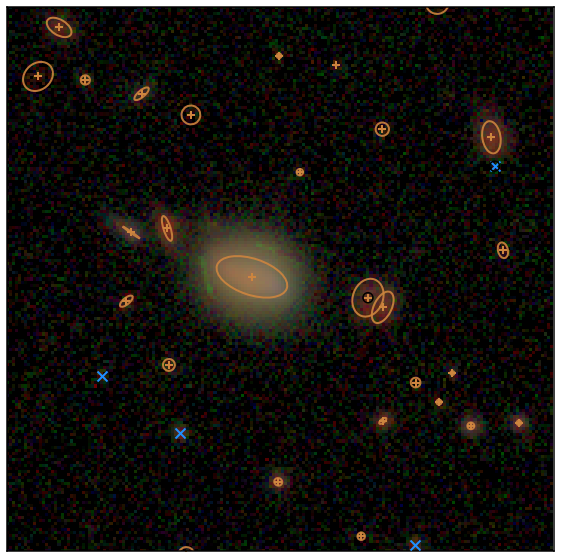

In [27]:
_ = plotting.cutout_show_objects(cutout_rgb, cutout_objs, xsize=10, cutout_wcs=cutout_wcs)

# 30/32 objects are clean.
# There are 4 point sources on the cutout
# There are 28 extended sources on the cutout


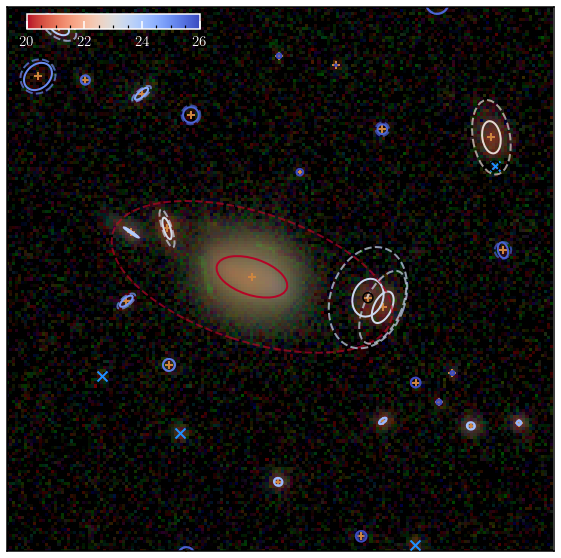

In [35]:
_ = plotting.cutout_show_objects(
    cutout_rgb, cutout_objs, show_clean=False, xsize=10, band='i', cbar_color='w',
    show_mag=True, show_weighted=False, scale_bar_color='k', cutout_wcs=cutout_wcs)

### Recontruct the `CModel`

In [37]:
import galsim

In [39]:
cutout = task.hsc_cutout(
    coord, cutout_size=s_ang, redshift=None, filters='i', 
    archive=pdr2_w, use_saved=False, verbose=True, save_output=False)

# Retrieving cutout image in filter: i


In [40]:
psf_i = task.hsc_psf(coord, filters='i', archive=pdr2_w, save_output=False)[0].data

# Retrieving coadd PSF model in filter: i


In [46]:
objs_test = catalog.world_to_image(cutout_objs, cutout_wcs, update=True)

objs_exp = catalog.moments_to_shape(
    objs_test, shape_type='cmodel_exp_ellipse', axis_ratio=True, to_pixel=True, update=True)

objs_dev = catalog.moments_to_shape(
    objs_test, shape_type='cmodel_dev_ellipse', axis_ratio=True, to_pixel=True, update=True)

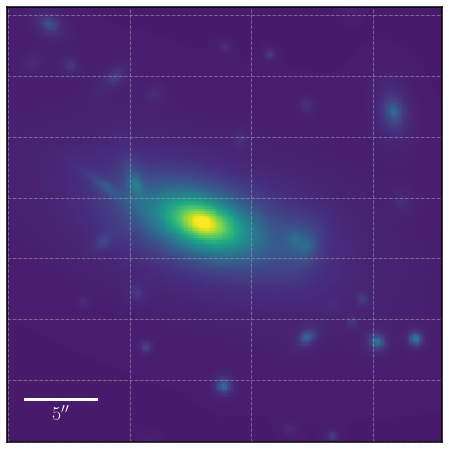

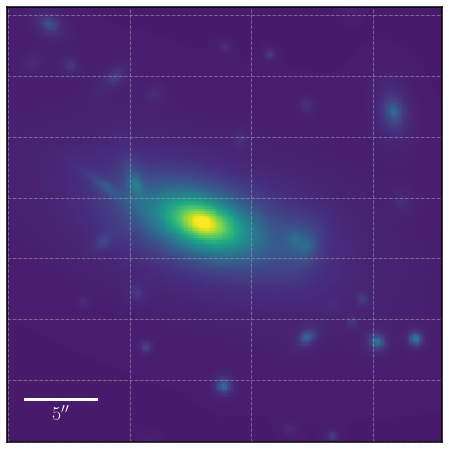

In [47]:
extended = 'i_extendedness'

obj_exp = objs_exp[(objs_exp['psf_mag'] > 0) | (objs_exp['cmodel_mag'] > 0)]
exp_model = catalog.objects_to_galsim(cutout[1].data, obj_exp, psf_model=psf_i)

obj_dev = objs_dev[(objs_dev['psf_mag'] > 0) | (objs_dev['cmodel_mag'] > 0)]
dev_model = catalog.objects_to_galsim(cutout[1].data, obj_dev, psf_model=psf_i)

_ = plotting.display_single(
    exp_model, zmin=np.nanmin(cutout[1].data), zmax=np.nanmax(cutout[1].data))

_ = plotting.display_single(
    dev_model, zmin=np.nanmin(cutout[1].data), zmax=np.nanmax(cutout[1].data))

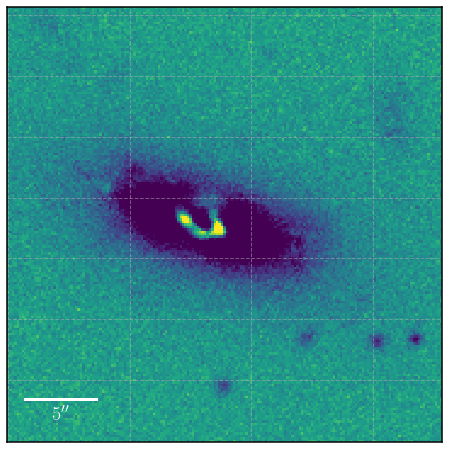

In [50]:
_ = plotting.display_single(
    cutout[1].data - exp_model, scale='zscale')

### Compare the difference between `S20A` Wide and DUD

- α=10:03:10.4759 δ=+02:23:18.9771 ∠=3.3978′
- α=150.793650° δ=2.388605° ∠=0.056630

In [26]:
#coord = SkyCoord(sample[1]['ra'], sample[1]['dec'], frame='icrs', unit='deg')
coord = SkyCoord(150.793650, 2.388605, frame='icrs', unit='deg')

# Angular size
s_ang = 20.0 * u.arcsec
s_box = s_ang * 1.0

# Filter
filters = 'gri'

#### `S20A_WIDE`

In [66]:
# Use angular size and don't save the data
cutout_rgb, cutout_wcs = task.hsc_tricolor(
    coord, cutout_size=s_ang, filters=filters, verbose=True, 
    save_rgb=False, save_img=False, use_saved=False, archive=s20a_w)

# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i


In [102]:
cutout_objs = task.hsc_box_search(
    coord, box_size=s_box, redshift=None, archive=s20a_w,
    verbose=True, psf=True, cmodel=True, aper=True, shape=True,
    meas='i', flux=False, aper_type='3_20')

# Select "clean" images
cutout_clean, clean_mask = catalog.select_clean_objects(
    cutout_objs, return_catalog=True, verbose=True)

Waiting for query to finish... [Done]
# 52/69 objects are clean.


# 52/69 objects are clean.
# There are 9 point sources on the cutout
# There are 43 extended sources on the cutout


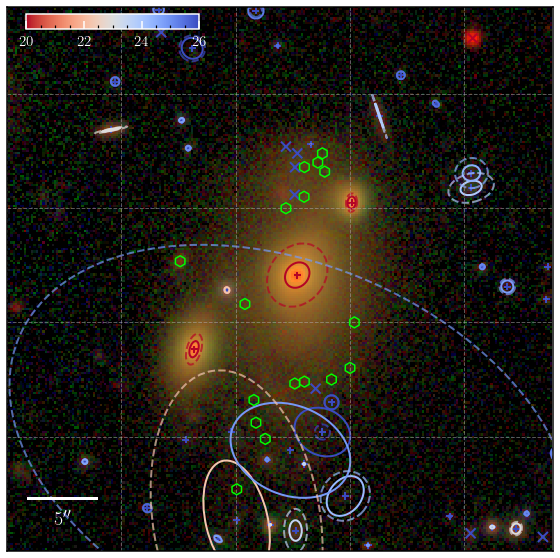

In [105]:
_ = plotting.cutout_show_objects(
    cutout_rgb, cutout_objs, show_clean=True, xsize=10, band='i', cbar_color='w',
    show_mag=True, show_weighted=False, cutout_wcs=cutout_wcs, scale_bar_length=5)

#### `S20A_DUD`

In [106]:
# Use angular size and don't save the data
cutout_rgb, cutout_wcs = task.hsc_tricolor(
    coord, cutout_size=s_ang, filters=filters, verbose=True, 
    save_rgb=False, save_img=False, use_saved=False, archive=s20a_d)

# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i


In [107]:
cutout_objs = task.hsc_box_search(
    coord, box_size=s_box, redshift=None, archive=s20a_d,
    verbose=True, psf=True, cmodel=True, aper=True, shape=True,
    meas='i', flux=False, aper_type='3_20')

# Select "clean" images
cutout_clean, clean_mask = catalog.select_clean_objects(
    cutout_objs, return_catalog=True, verbose=True)

Waiting for query to finish... [Done]
# 21/75 objects are clean.


# 21/75 objects are clean.
# There are 17 point sources on the cutout
# There are 58 extended sources on the cutout


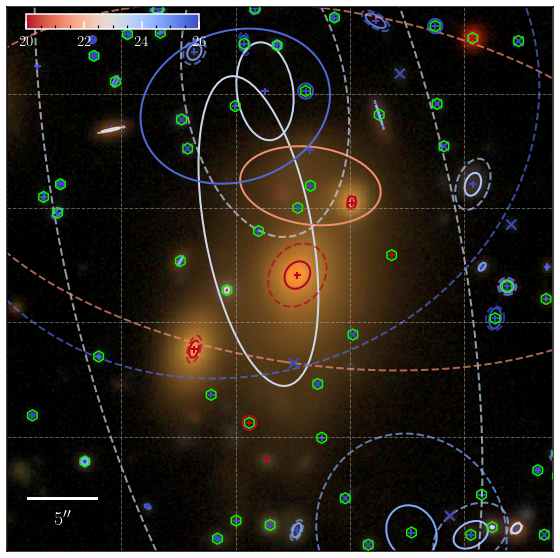

In [108]:
_ = plotting.cutout_show_objects(
    cutout_rgb, cutout_objs, show_clean=False, xsize=10, band='i', cbar_color='w',
    show_mag=True, show_weighted=False, scale_bar_color='w', cutout_wcs=cutout_wcs)